In [7]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

import skimage.segmentation as sk_seg
import copy
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from skimage.filters import threshold_multiotsu
import jenkspy
import sklearn.cluster as skclus
import pandas as pd

from helpers import *
from alignment import *
import segmentation
from segmentation import *
reload(segmentation)

import grouping
from grouping import *
reload(grouping)

import visualization
from visualization import *
reload(visualization)

import statsmodels.api as sm
import scipy
from scipy.ndimage import gaussian_filter1d
import time
import functools



In [2]:
import pandas as pd

# df = pd.read_csv('100222-ENU-Mouse-Normalisation-Data.csv',sep=',')
df = pd.read_csv('../../data/080322-ENU-Mouse-Normalisation-Data-Gated.csv',sep=',')
# df = pd.read_csv('100222-ENU-Mouse-Normalisation-Data-Raw.csv',sep=',')
columns_names = df.columns.tolist()
samples_codes = df['sample_code']
samples_codes = np.unique(samples_codes)
samples_codes = np.unique([e.split('-')[0]for e in samples_codes])

X = []
Y = []

for i, s in enumerate(samples_codes):
    sample_train = df[df['sample_code'].str.contains(s)].to_numpy()[:,1:].astype(np.float)
    X += [sample_train]
    y = i*np.ones(shape= sample_train.shape[0])
    Y+=[y]

X = np.concatenate(X)
Y = np.concatenate(Y)
print(X.shape)
print(Y.shape)
max_before_norm, min_before_min = X.max(0), X.min(0)
X = MinMaxScaler().fit_transform(X)
num_samples = len(np.unique(Y))
num_channels = 15
segments = np.ones(shape=[num_channels, num_samples])*-1


(1864976, 17)
(1864976,)


In [3]:
print(X)

[[4.61656230e-01 3.50435862e-01 6.15567783e-01 ... 5.32111263e-01
  1.12091291e-05 0.00000000e+00]
 [5.39324518e-01 4.66241785e-01 5.34353340e-01 ... 5.13521974e-01
  1.68136941e-05 1.09115033e-06]
 [2.64806506e-01 2.68962665e-01 4.67389717e-01 ... 4.47765724e-01
  2.24182583e-05 2.18230067e-06]
 ...
 [6.74501193e-01 5.42674613e-01 5.86886638e-01 ... 5.62703870e-01
  3.33925562e-01 6.94603389e-01]
 [5.41801305e-01 4.10751766e-01 6.22839666e-01 ... 6.24601028e-01
  3.33947975e-01 6.94606662e-01]
 [7.10230904e-01 5.47040890e-01 6.21770615e-01 ... 4.51179550e-01
  3.33964777e-01 6.94608844e-01]]


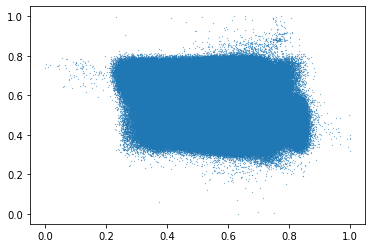

In [4]:
plt.figure()
plt.scatter(X[:,10],X[:,14], s=.05)

In [5]:
gate_factor = 0.02
gate_factor = np.ones(15)*gate_factor if isinstance(gate_factor, float) else gate_factor
gate_factor[:8] = 0.01


kde_window= .28
kde_window = np.ones(15)*kde_window if isinstance(kde_window, float) else kde_window
kde_window[10] =.2
kde_window[6] =.1
area_thresholds = .04
area_thresholds = np.ones(15)*area_thresholds if isinstance(area_thresholds, float) else area_thresholds

distance_thresholds=.16
distance_thresholds = np.ones(15)*distance_thresholds if isinstance(distance_thresholds, float) else distance_thresholds

depth_thresholds =.23
depth_thresholds = np.ones(15)*depth_thresholds if isinstance(depth_thresholds, float) else depth_thresholds

In [6]:
num_ch = 15
samples = []
time_start= time.time()

for y in range(num_samples):
    s_d = X[Y == y, :]
    print('****\n'*4,'Sample:',y,'****\n'*4)
    sample = Sample(s_d, gates_per_channel=[-1]*num_ch, sample_num=y,
                    gate_factor_q=gate_factor,area_threshold=area_thresholds,
                    kde_window=kde_window,width_threshold=distance_thresholds,
                    depth_threshold=depth_thresholds)
    samples+=[sample]

data_handler = DataHandler(samples)
time_end = time.time()


****
****
****
****
 Sample: 0 ****
****
****
****

0.04 0.16 0.23
bounds [[-0.06019178513381404, 0.9516547887102804]]
tightened_bounds [[0.10939150989538232, 0.7734637633044684]]
0.04 0.16 0.23
bounds [[-0.110064294921875, 0.9116974357304789]]
tightened_bounds [[0.05747537266557383, 0.6867922418151456]]
0.04 0.16 0.23
bounds [[-0.044664160747411724, 1.1152219169743773]]
tightened_bounds [[0.2899683344466898, 0.9342105140367448]]
0.04 0.16 0.23
bounds [[-0.03965550466756676, 0.8427185021898683]]
tightened_bounds [[0.1114651530674474, 0.6902112786126942]]
0.04 0.16 0.23
bounds [[-0.045800032517254154, 0.7859718314236865]]
tightened_bounds [[0.10052722917176984, 0.4992501546522296]]
0.04 0.16 0.23
bounds [[0.007697560937830736, 0.9025668978437915]]
tightened_bounds [[0.09257003509793452, 0.39087858344185245]]
0.04 0.16 0.23
bounds [[0.06313968063718822, 1.0339356225800143]]
tightened_bounds [[0.37621899221682287, 0.8042874375910298]]
width 0.395 depth 0.8785568878066736 width_cond False


In [10]:
print(time_end-time_start)
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 14]

128.06625080108643


In [11]:
previous_KDE_window = copy.deepcopy(kde_window)

def interact_pick_channel(samples, channel):
    channel = columns_names.index(channel)-1
    area_threshold_widget  = widgets.FloatSlider(min=0.0, max=0.05, step=0.001, value=area_thresholds[channel], )
    width_threshold_widget = widgets.FloatSlider(min=0.0, max=0.6, step=.025, value=distance_thresholds[channel])
    depth_threshold_widget = widgets.FloatSlider(min=0.0, max=0.7, step=.025, value=depth_thresholds[channel])

    interact(interactive_update_segments,
         area_threshold = area_threshold_widget,
         width_threshold = width_threshold_widget,
         depth_threshold = depth_threshold_widget,
         channel = fixed(channel),
         samples=fixed(samples))

def interactive_update_segments(samples, channel, area_threshold, width_threshold,
                                depth_threshold):
     
        area_thresholds[channel] = area_threshold
        distance_thresholds[channel] = width_threshold
        depth_thresholds[channel] = depth_threshold


        for i, s in enumerate(samples):
            s.resegment_ch(channel, kde_window=None, area_threshold=area_threshold,
                              width_threshold=width_threshold,
                              depth_threshold=depth_threshold, init=False, verbose=False)

        plot_channel_segments(ch=channel,
                              samples=samples,
                               max_per_plt=20,show_labels=False,
                              limit_x0=-.2,limit_x1=1.2)

In [12]:
from ipywidgets import interact, interactive, fixed, interact_manual

import ipywidgets as widgets
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 38em; }</style>"))

In [13]:
#     max_per_plt_widget = widgets.IntSlider(min=2, max=len(samples), step=1, value=15)
ch_widget = widgets.ToggleButtons(
    options=columns_names[1:-2],
    description='Channel',
    disabled=False,
    style={"button_width": "100px"}
)
ch = ch_widget.index
# def update_x_range(*args):
#     x_widget.max = 2.0 * y_widget.value
# y_widget.observe(update_x_range, 'value')

# kde_window_widget = widgets.FloatSlider(min=0.0, max=0.6, step=.025, value=kde_window[ch])
interact(interact_pick_channel,
         channel = ch_widget,
         samples=fixed(samples))

interactive(children=(ToggleButtons(description='Channel', options=('FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H…

<function __main__.interact_pick_channel(samples, channel)>

In [8]:
data_handler = DataHandler(samples, verbose=False)
# print(np.array(columns_names)[np.argwhere(samples[0].area_threshold !=.02).flatten()+1])
print(samples[0].depth_threshold)
print(samples[0].depth_threshold)

[0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23
 0.23]
[0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23 0.23
 0.23]


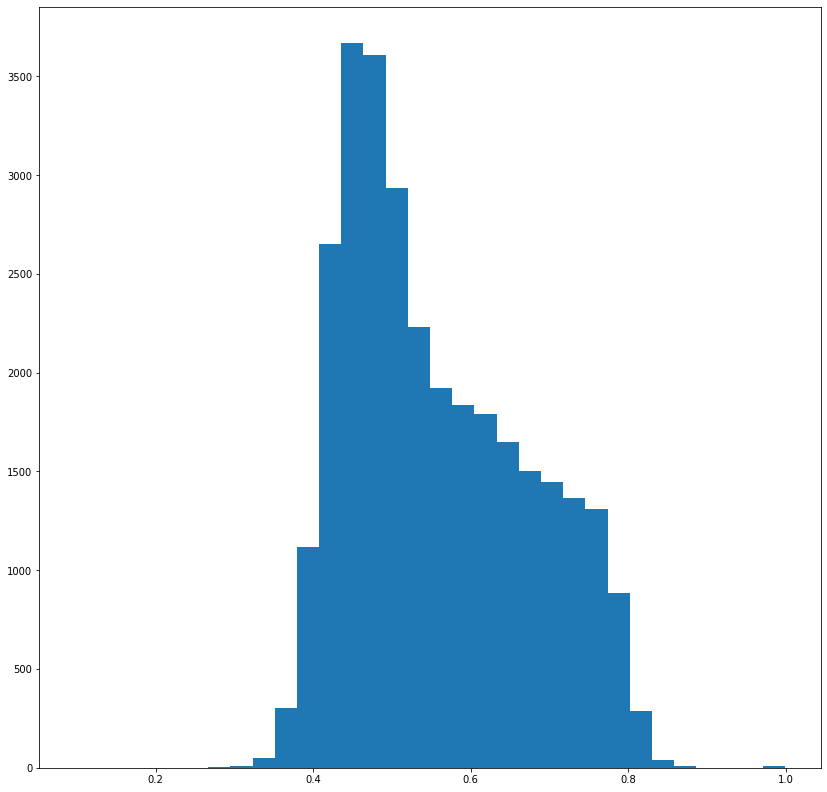

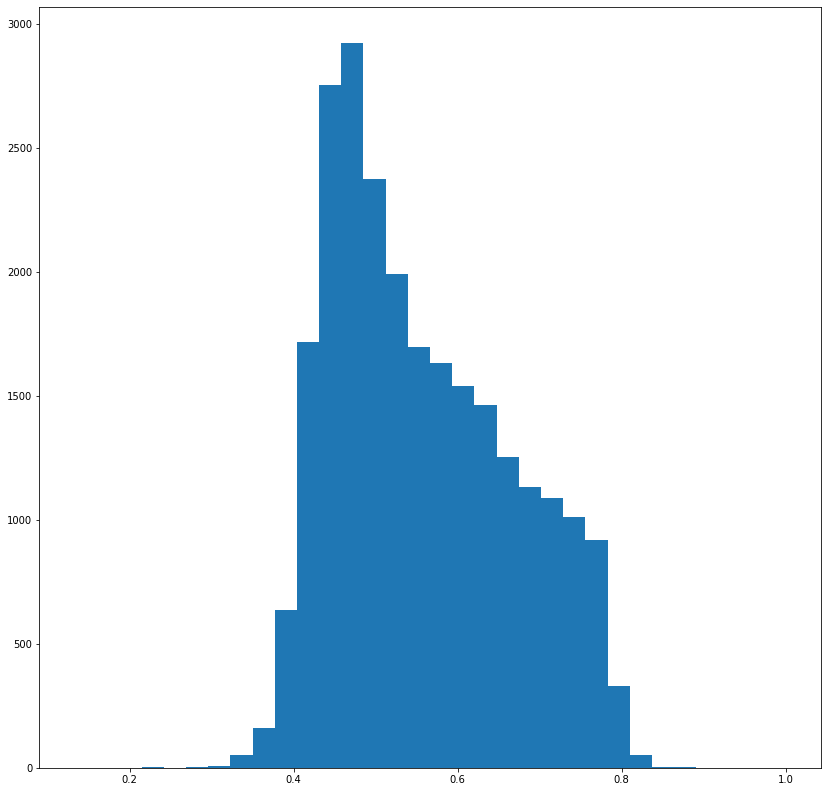

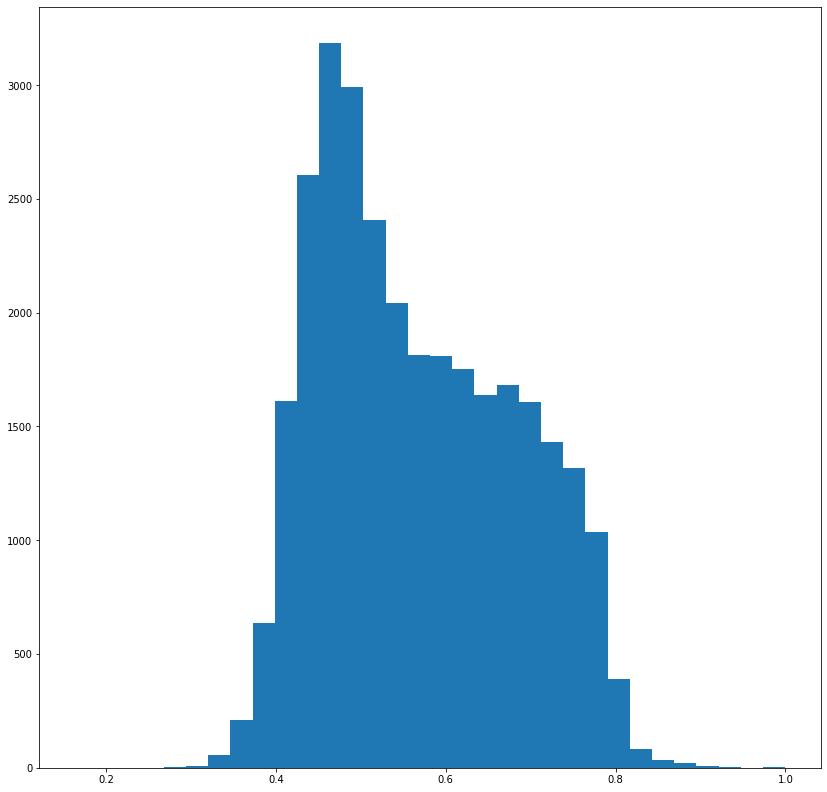

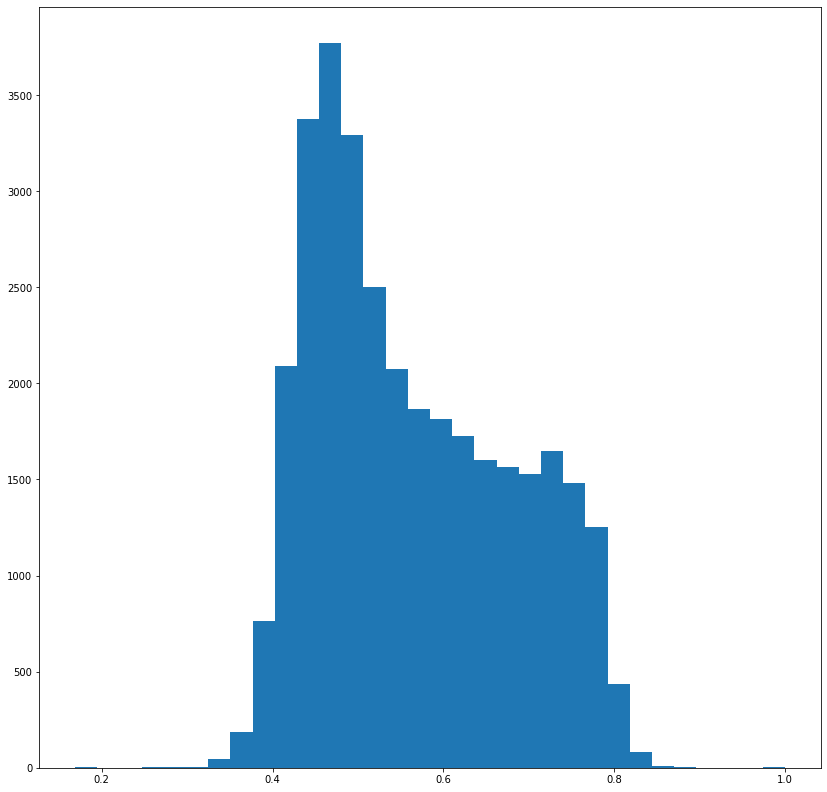

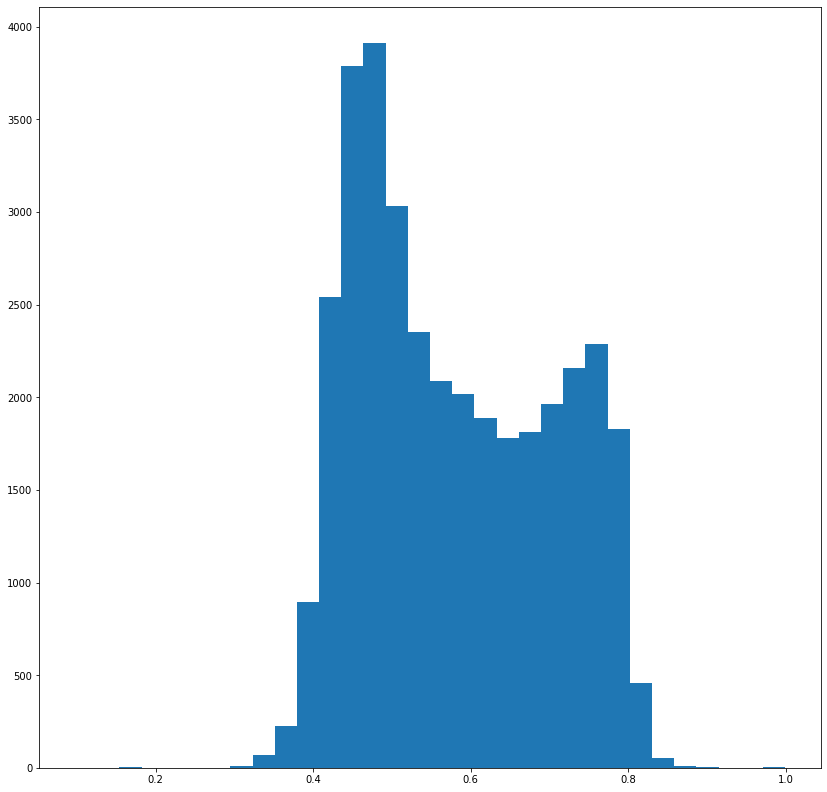

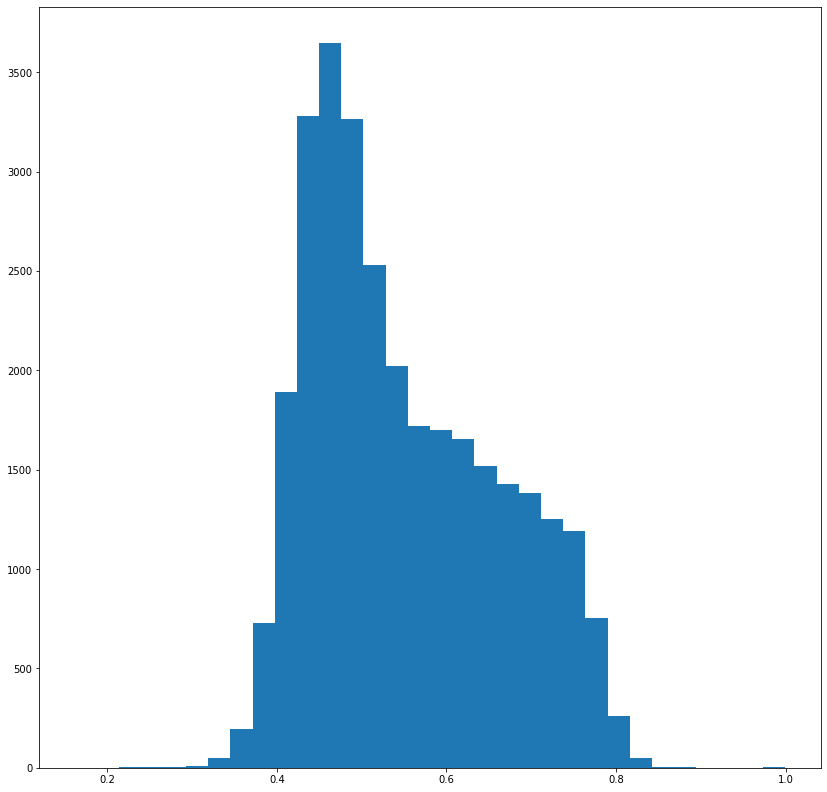

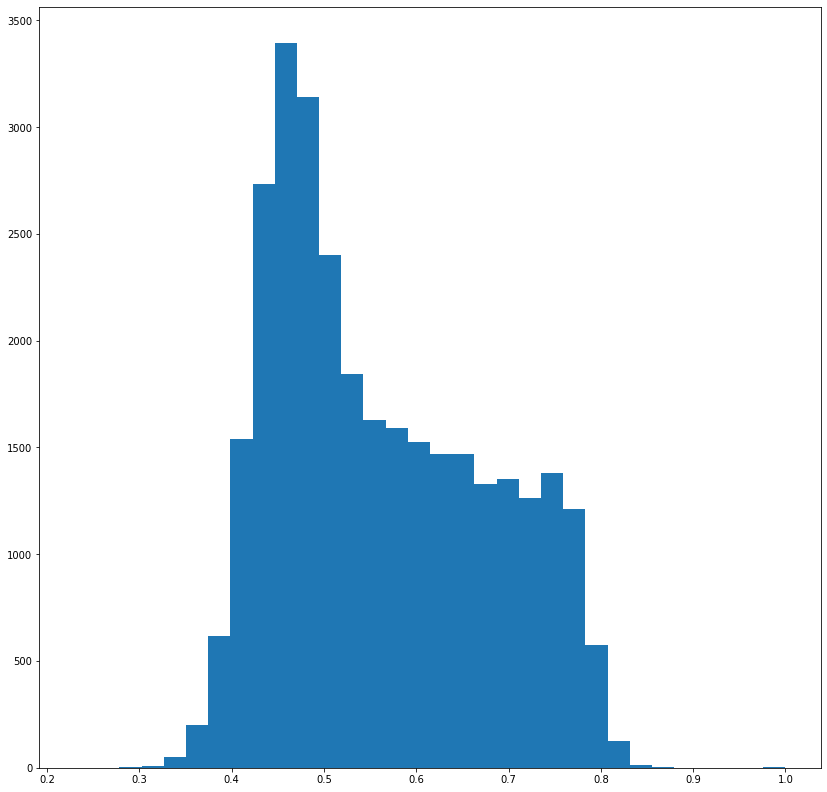

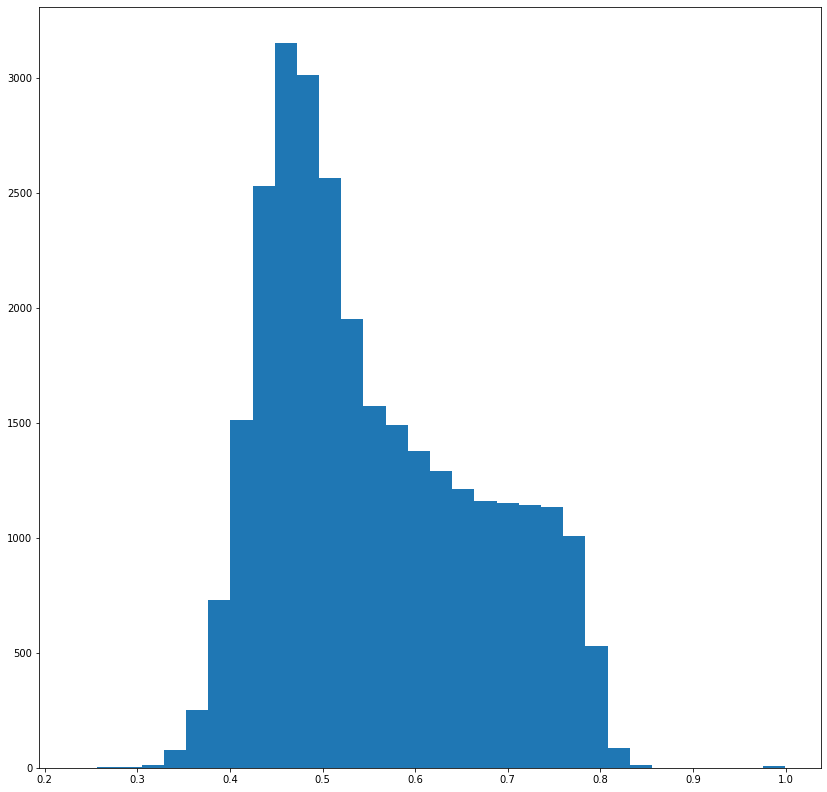

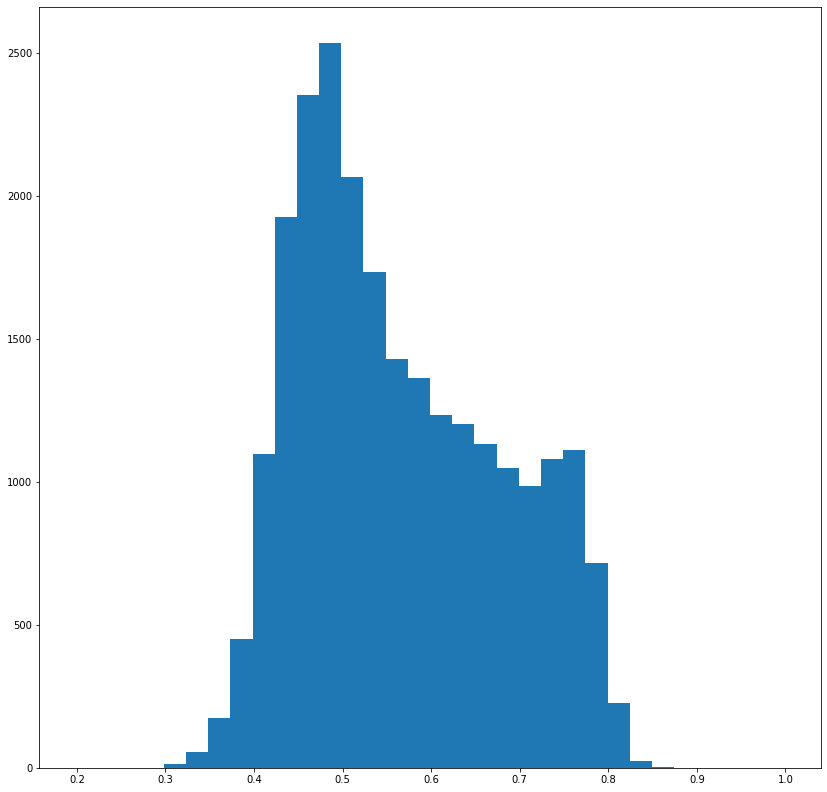

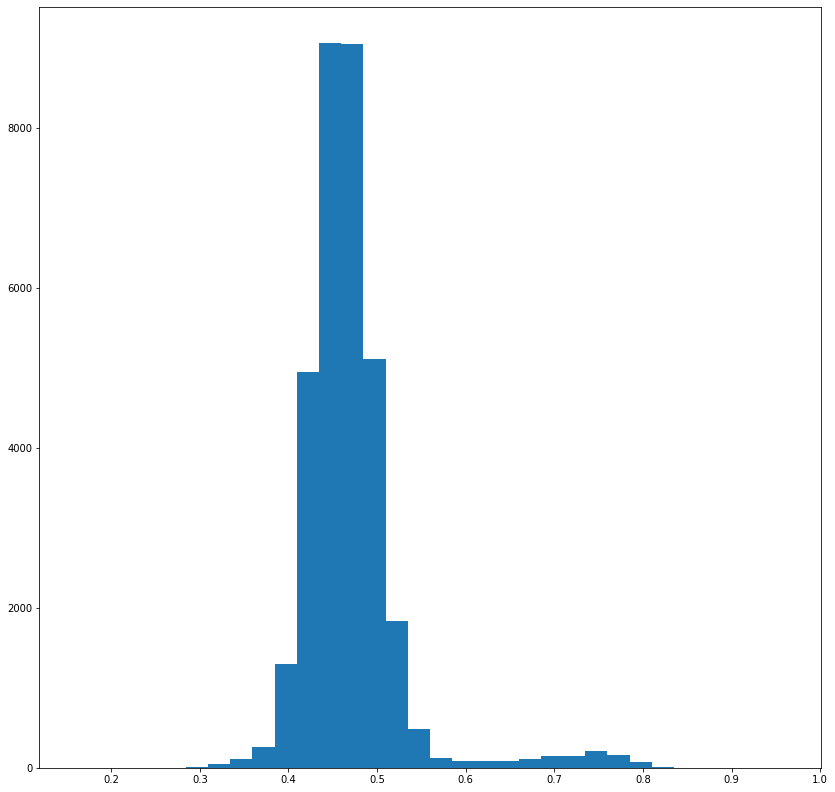

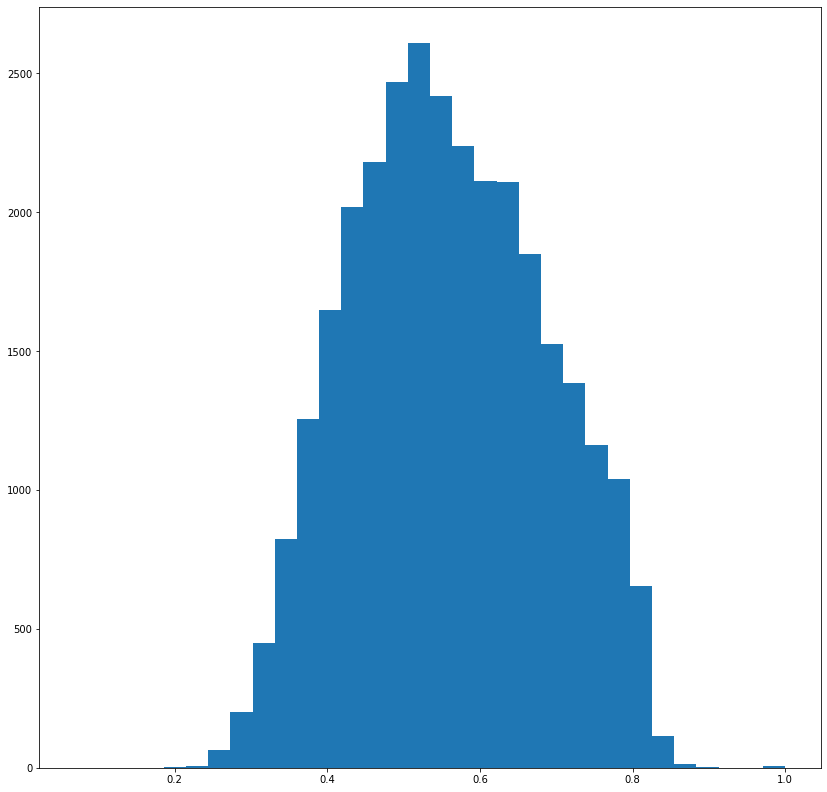

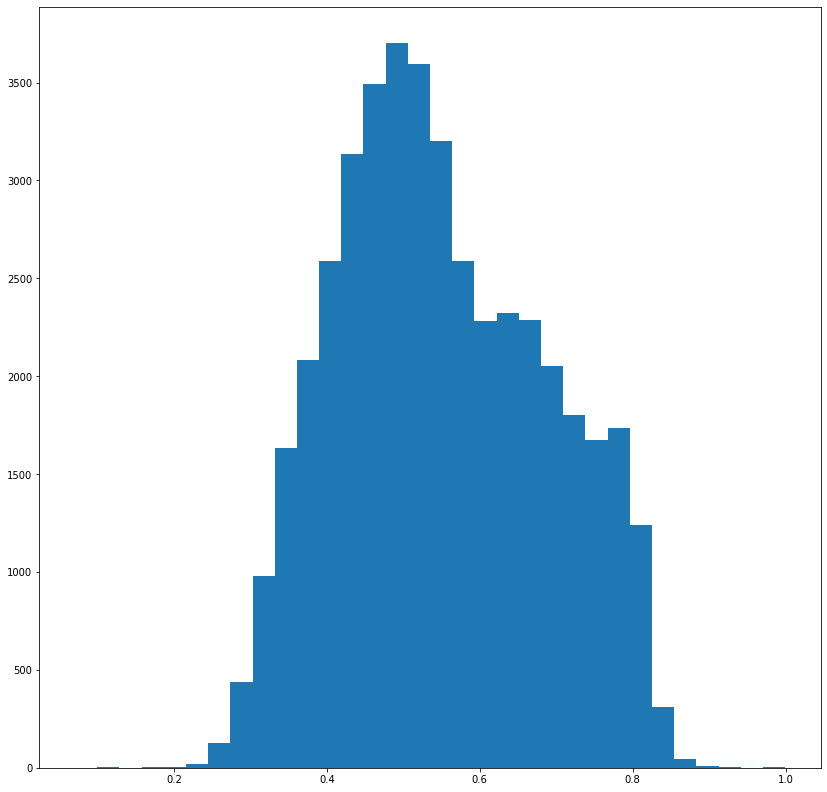

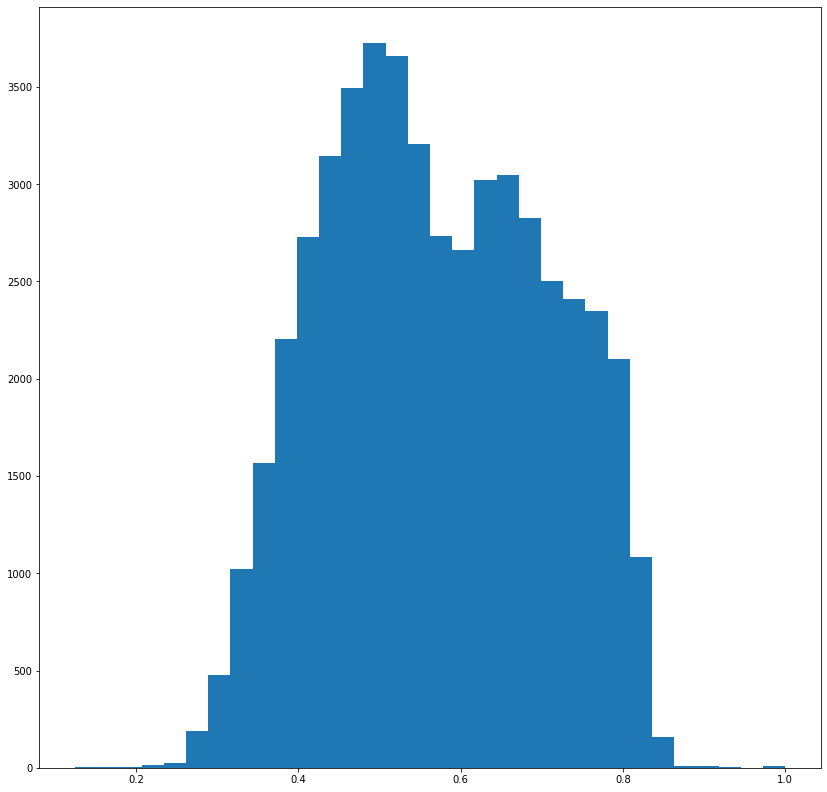

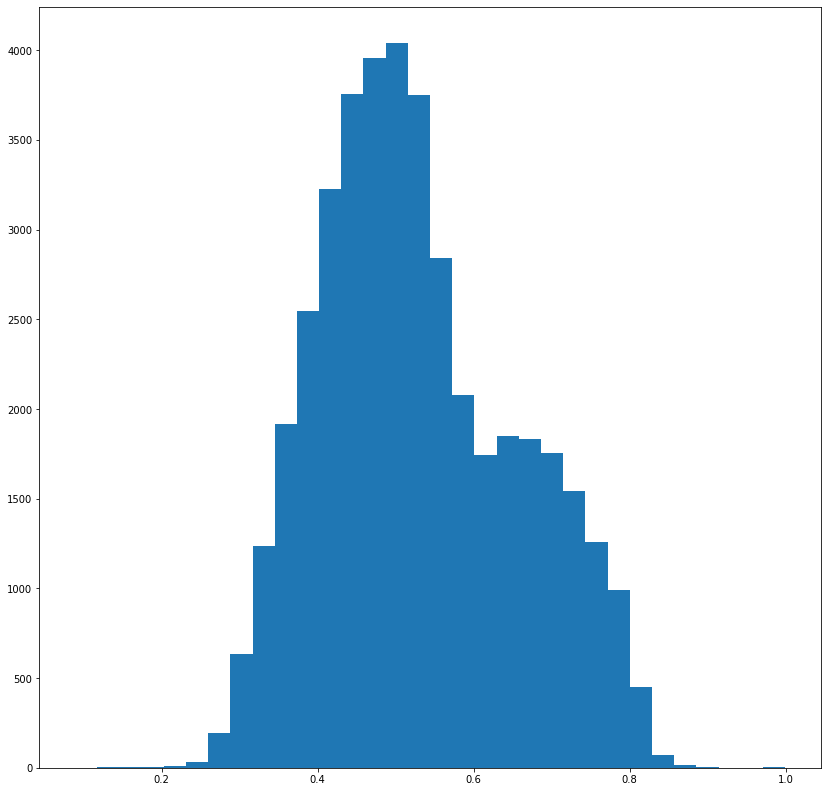

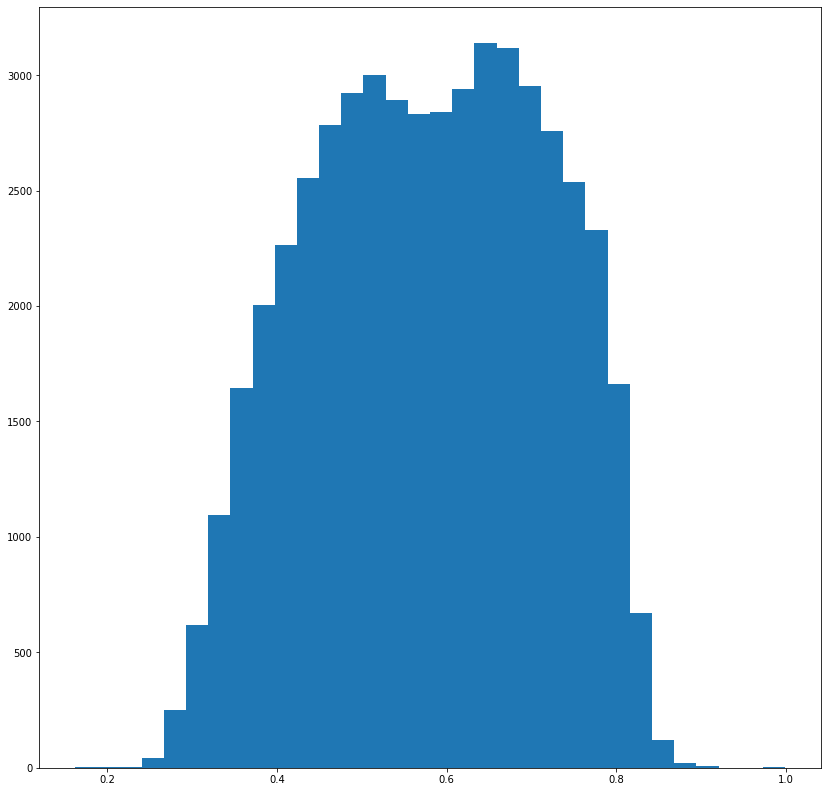

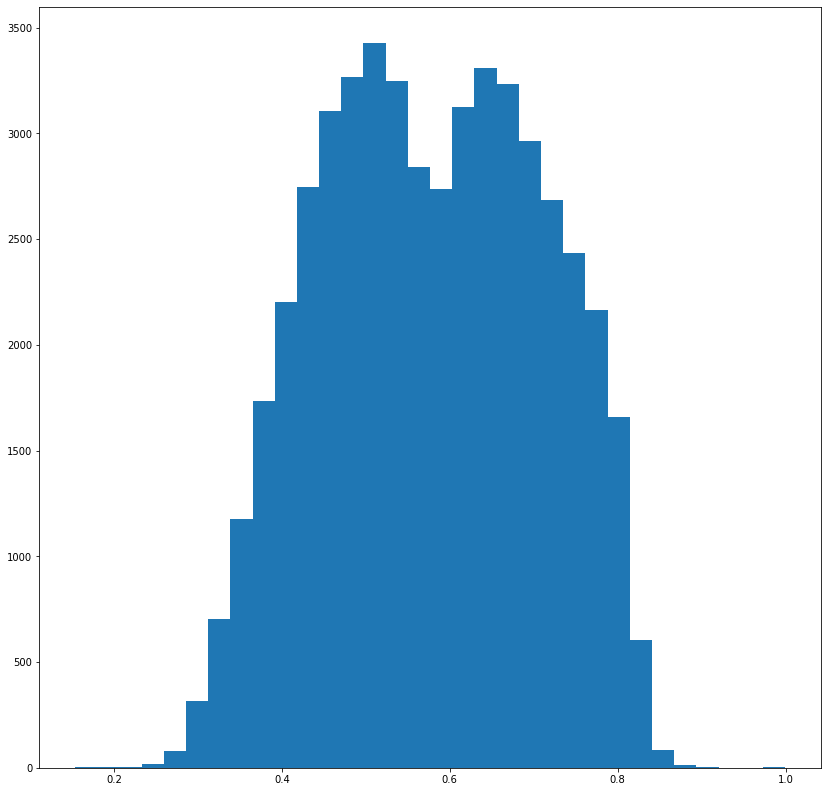

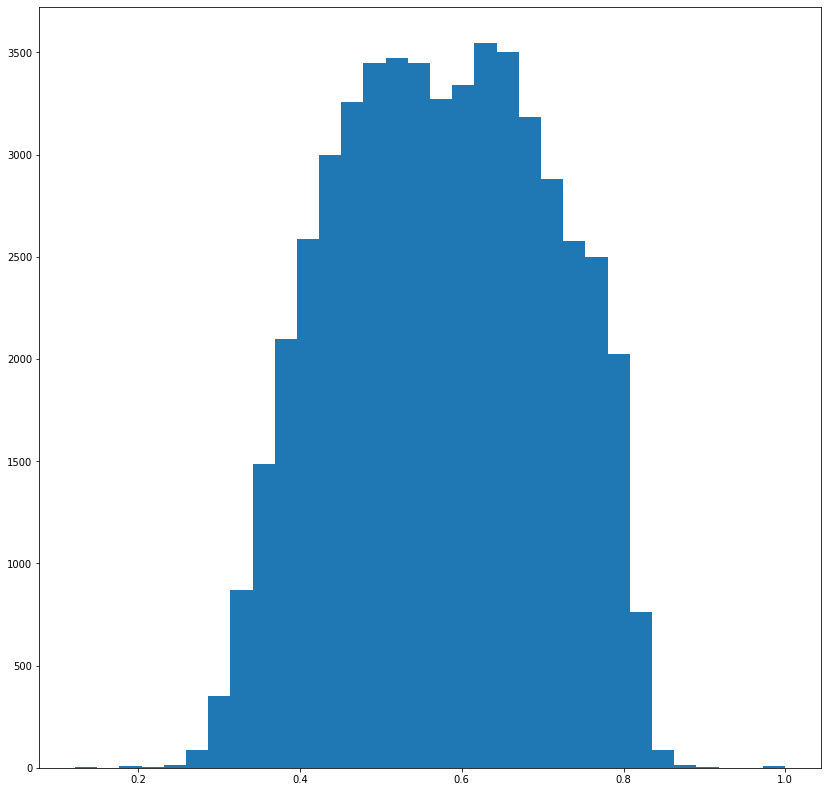

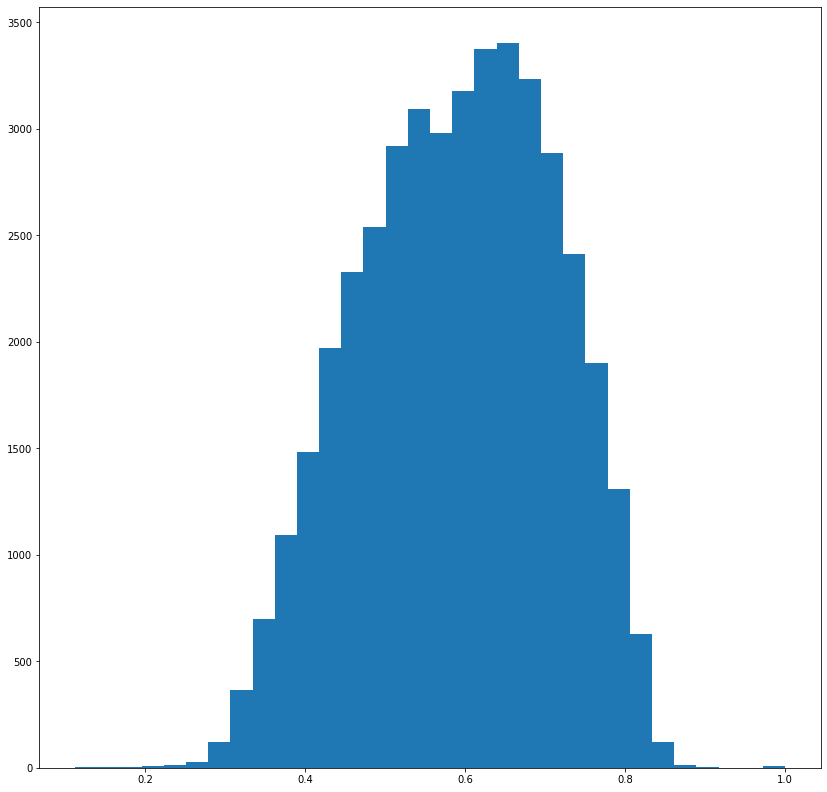

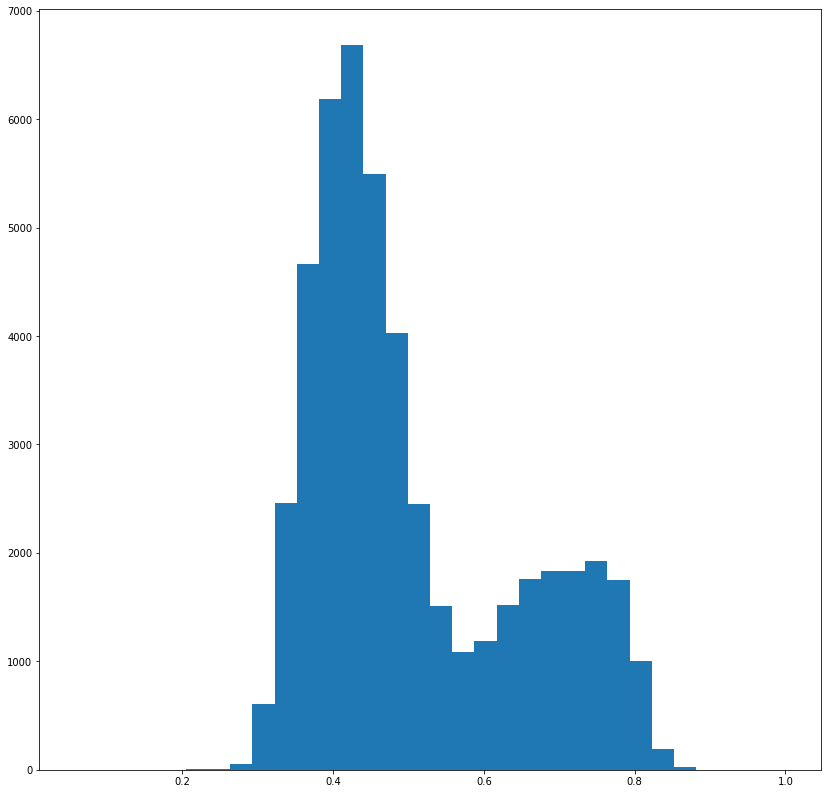

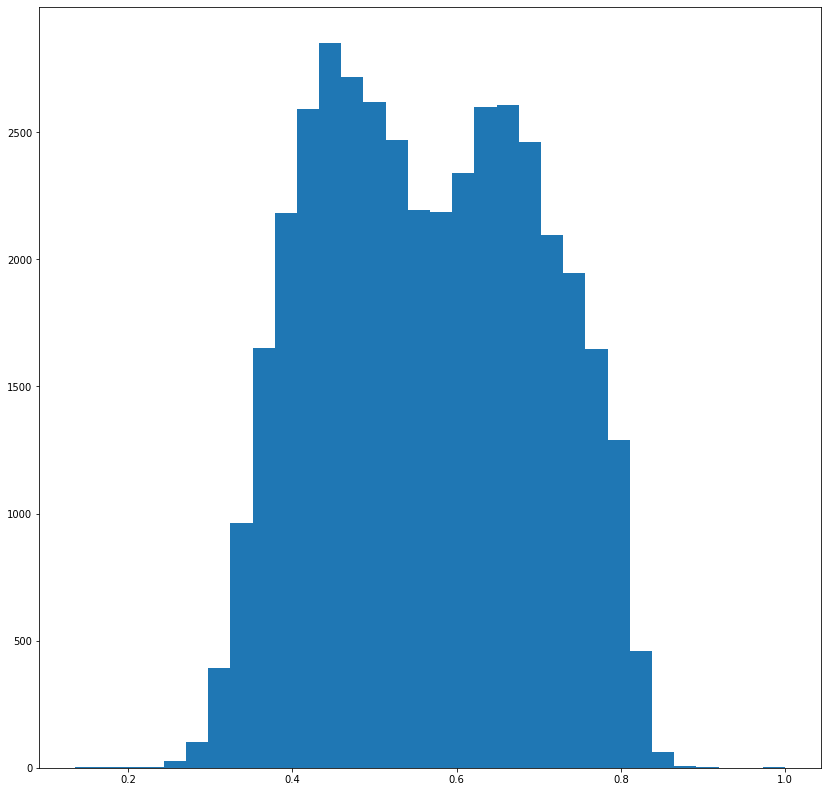

In [168]:
# for i in range(20):
#     plt.figure()
#     a = plt.hist(X[Y==i,6], bins=32)



In [ ]:
# aligned_sample = {}
# ref_num, targ_num = 2, 4
# gates_locations_dict = {}
# funcs_dict = {}
# xys_dict = {}
# for ch in [13,14]:
#     funcs  = []
#     xys  = []
#     ch_aligned = []
#     gates_locations = []
#
#     for i in range(2):
#         ref_gate = samples[ref_num].gates[ch][i]
#         ref_seg1 = ref_gate.segment
#         ref_ecdf = sm.distributions.empirical_distribution.ECDF(ref_seg1)
#         target_gate = samples[targ_num].gates[ch][i]
#         target_seg1 = target_gate.segment
#         target_ecdf = sm.distributions.empirical_distribution.ECDF(target_seg1)
#
#         ref_inv_cdf = sm.distributions.empirical_distribution.monotone_fn_inverter(ref_ecdf,
#                                                                                    ref_seg1)
#
#
#         ref_inv_cdf = scipy.interpolate.BSpline(
#             ref_inv_cdf.x,
#             ref_inv_cdf.y,
#                                                          k=0,
#                                                          extrapolate=False
#                                                          )
#
#         func0 = lambda_warp_factory(ref_inv_cdf, target_ecdf)
#         funcs += [func0]
#
#         plt.figure()
#         ax1 = plt.subplot2grid((3,2), (0,0),rowspan=1, colspan=1)
#         ax1.set_xlim(0,1)
#         ax1.set_ylabel('reference')
#         ax2 = plt.subplot2grid((3,2), (1,0),rowspan=1, colspan=1)
#         ax2.set_ylabel('target')
#         ax2.set_xlim(0,1)
#         ax3 = plt.subplot2grid((3,2), (2,0),rowspan=1, colspan=1)
#         ax3.set_ylabel('aligned')
#         ax3.set_xlim(0,1)
#         ax4 = plt.subplot2grid((3,2), (0,1),rowspan=3, colspan=1)
#
#         sns.distplot(ref_seg1, ax = ax1,hist=False, bins=128)
#         sns.distplot(target_seg1, ax = ax2, hist=False,bins=128)
#         aligned = func0(target_gate.segment)
#         ch_aligned+=[aligned]
#
#         print('nans',np.count_nonzero(np.isnan(aligned)))
#         sns.distplot(aligned, ax = ax3, hist=False, bins=128)
#
#         t = np.linspace(target_gate.tight_gate[0],target_gate.tight_gate[1],1000)
#         y = func0(t)
#         ind = ~np.isnan(y)
#         xys +=[[t[ind],y[ind]]]
#         ax4.plot(t, t)
#         ax4.plot(t, ref_ecdf(t))
#         ax4.plot(t, ref_inv_cdf(t))
#
#         ax4.plot(t, y)
#         gates_locations += [[target_gate.tight_gate[0], target_gate.tight_gate[1]]]
#         for l in [ref_gate.tight_gate[0], ref_gate.tight_gate[1]]:
#             ax4.axhline(l)
#         for l in [target_gate.tight_gate[0], target_gate.tight_gate[1]]:
#             ax4.axvline(l)
#         ax4.grid(True)
#     gates_locations_dict[ch] = gates_locations
#     aligned_sample[ch] = np.concatenate(ch_aligned)
#     funcs_dict[ch] = funcs
#     xys_dict[ch] = xys
#

In [ ]:
# comp_func0 = combine_funcs(funcs_dict[13], gates_locations_dict[13])
# comp_func1 = combine_funcs(funcs_dict[14], gates_locations_dict[14])
# comp_funcs = [comp_func0, comp_func1]
#

In [ ]:
# # locs = [[.2,.5], [.6,.8]]
# locs = gates_locations_dict[13]
# # funcs = [lambda x:x*x, lambda x:1.2*x]
# funcs = funcs_dict[13]
# comp_func = combine_funcs(xys_dict[13])
# plt.figure()
# t = np.linspace(0,1, 1000)
# plt.plot(t, t)
# t = np.linspace(*locs[0], 1000)
# plt.plot(t, funcs[0](t),linewidth=2)
# t = np.linspace(*locs[1], 1000)
# plt.plot(t, funcs[1](t),linewidth=2)
# t = np.linspace(0,1, 1000)
# plt.plot(t, comp_func(t))
#

In [ ]:
# tch1 = samples[targ_num](13).reshape(-1,1)
# tch2 = samples[targ_num](14).reshape(-1,1)
# ach1 = comp_funcs[0](tch1)
# ach2 = comp_funcs[1](tch2)
#
# axes = plt.subplots(3,1)[1].flatten()
# sns.distplot(samples[ref_num](14), hist=True, bins=128, ax = axes[0])
# sns.distplot(tch2, hist=True, bins=128, ax = axes[1])
# sns.distplot(ach2, hist=True, bins=128, ax = axes[2])
# axes[0].set_xlim(0,1)
# axes[1].set_xlim(0,1)
# axes[2].set_xlim(0,1)
#
# plot_lines( np.concatenate([tch1,
#                           tch2], axis=1),
#            np.concatenate([ach1,
#                           ach2], axis=1),n_lines=10000,
#             s1=5, s2=10
#            )
#

In [ ]:
# plt.figure()
# # plt.scatter(tch1,tch2, s= 2, alpha=.4, c='b')
# plt.scatter(ach1,ach2, s= 2, alpha=.4, c='g')
#

In [ ]:
# sns.distplot(samples[ref_num](14), hist=False, bins=128)
# sns.distplot(tch2, hist=False, bins=128)
# sns.distplot(ach2, hist=False, bins=128)
#

In [ ]:
# xx, yy = np.meshgrid(np.linspace(0,1,50),np.linspace(0,1,50))
# xx = xx.reshape(-1,1)
# yy = yy.reshape(-1,1)
# TD = np.concatenate([xx,yy], axis=1)
# AD = np.concatenate([comp_funcs[0](xx), comp_funcs[1](yy)], axis=1)
# plot_lines(TD, AD, 50**2,linewidth=1, s1=5, s2=15)
#
#

In [14]:
Sim_Matrix_dict = {}
agg_models_dict = {}
location_groups_dict = {}
Loc_Ref_Dict_All_Ch = {}
incidence_matrcies = {}
loosened_groups_for_deadlock_dict = {}
jaccard_thresholds = 0.6
jaccard_thresholds = np.ones(15)*jaccard_thresholds if isinstance(jaccard_thresholds, float) else jaccard_thresholds


In [15]:
import grouping
reload(grouping)
from grouping import *

import visualization
reload(visualization)

from visualization import *


In [16]:
# recompute_and_update_location_hierarchy_and_refs(
#                                 channels=list(range(num_channels)),
#                                 # channels=[5],
#                                 jaccard_thresholds=jaccard_thresholds,
#                                 data_handler=data_handler,
#                                 Sim_Matrix_dict=Sim_Matrix_dict,
#                                 agg_models_dict=agg_models_dict,
#                                 location_groups_dict=location_groups_dict,
#                                 Loc_Ref_Dict_All_Ch=Loc_Ref_Dict_All_Ch,
#                                 incidence_matrcies = incidence_matrcies,
#     loosened_groups_for_deadlock_dict = loosened_groups_for_deadlock_dict
#                                    )
#
# data_handler = DataHandler(samples, verbose=False)

ch 0
here
Unique groups [1] 


[[60.]]
optimal gates:
(1, 0, 0.0) [-0.06019178513381404, 0.9516547887102804]
constraints []
No Constraints
ch 1
here
Unique groups [1] 


[[60.]]
optimal gates:
(1, 0, 0.0) [-0.110064294921875, 0.9116974357304789]
constraints []
No Constraints
ch 2
here
Unique groups [1 2] 


[[60.  1.]
 [ 1.  1.]]
[1, 2]
optimal gates:
(1, 0, 0.0) [-0.044664160747411724, 1.1152219169743773]
(2, 18, 0.0) [-0.036967689244451624, 0.35169234352141765]
constraints [[1, 2]]
iter 0 [[1, 2]]
ch 3
here
Unique groups [1 2] 


[[50.  0.]
 [ 0. 10.]]
optimal gates:
(1, 0, 0.0) [-0.03965550466756676, 0.8427185021898683]
(2, 40, 0.0) [-0.031978756791340004, 0.37470706598036974]
constraints []
No Constraints
ch 4
here
Unique groups [1 2 3] 


[[50.  1.  0.]
 [ 1.  1.  0.]
 [ 0.  0. 10.]]
[1, 2]
optimal gates:
(1, 0, 0.0) [-0.045800032517254154, 0.7859718314236865]
(2, 13, 0.0) [-0.08835566178616536, 0.16852551438485705]
(3, 40, 0.0) [-0.017254181892555186, 0.28115523767945483]
constra

In [17]:
%matplotlib inline

In [18]:
def interact_pick_channel(samples, channel,
                          jaccard_thresholds,
                         data_handler, Sim_Matrix_dict, agg_models_dict,
                         location_groups_dict, Loc_Ref_Dict_All_Ch,
                                                   incidence_matrcies,
                                                   loosened_groups_for_deadlock_dict,
                                                   mode
                         ):
    channel = columns_names.index(channel)-1

    jaccard_threshold_widget = widgets.FloatSlider(min=0.4, max=0.9, step=.05, value=jaccard_thresholds[channel])
    
    interact(interactive_recompute_and_update_location_hierarchy_and_refs,
         ch= fixed(channel),
         jaccard_threshold = jaccard_threshold_widget,
         jaccard_thresholds = fixed(jaccard_thresholds),
         data_handler=fixed(data_handler),
         Sim_Matrix_dict=fixed(Sim_Matrix_dict),
         agg_models_dict=fixed(agg_models_dict),
         location_groups_dict=fixed(location_groups_dict),
         Loc_Ref_Dict_All_Ch=fixed(Loc_Ref_Dict_All_Ch),
         incidence_matrcies = fixed(incidence_matrcies),
         loosened_groups_for_deadlock_dict= fixed(loosened_groups_for_deadlock_dict),
         mode = fixed(mode)
         )



def interactive_recompute_and_update_location_hierarchy_and_refs(ch,
                                                   jaccard_threshold,
                                    jaccard_thresholds,
                                    data_handler,
                                    Sim_Matrix_dict, agg_models_dict,
                                    location_groups_dict,
                                    Loc_Ref_Dict_All_Ch,
                                                   incidence_matrcies,
                                                   loosened_groups_for_deadlock_dict,
                                                   mode):
    
    
    jaccard_thresholds[ch]= jaccard_threshold
    recompute_and_update_location_hierarchy_and_refs(
                                channels=[ch],
                                data_handler=data_handler,
                                jaccard_thresholds=jaccard_thresholds,
                                Sim_Matrix_dict=Sim_Matrix_dict,
                                agg_models_dict=agg_models_dict,
                                location_groups_dict=location_groups_dict,
                                Loc_Ref_Dict_All_Ch=Loc_Ref_Dict_All_Ch,
        loosened_groups_for_deadlock_dict = loosened_groups_for_deadlock_dict,
        incidence_matrcies = incidence_matrcies
                                   )
    

    print('hello')
    plot_gates_dendrogram(agg_models_dict[ch],ch, jaccard_threshold, columns_names[ch+1])
    plt.figure()
    plot_gate_as_tiles(data_handler, ch, Loc_Ref_Dict_All_Ch)
    if mode==1 or mode ==2:
        plt.figure()
        plot_network_graph(ch, incidence_matrcies[ch], columns_names)
        plt.figure()
        sns.heatmap(Sim_Matrix_dict[ch], cmap='Blues')
        if mode ==2:  
            plot_channel_segments(ch=ch,
                               samples=samples,
                               max_per_plt=20,show_labels=False, color_fill_lg= True,
                               limit_x0=-.2,limit_x1=1.2)
            
ch_widget = widgets.ToggleButtons(
    options=columns_names[1:-2],
    description='Channel',
    disabled=False,
    style={"button_width": "100px"}
)

mode_widget = widgets.Dropdown(
    options=[0, 1, 2],
    value=0,
    description='Mode:',
    disabled=False,
)
data_handler = DataHandler(samples, verbose=False)

interact(interact_pick_channel,
         samples = fixed(samples),
         channel = ch_widget,
         jaccard_thresholds = fixed(jaccard_thresholds),
         data_handler = fixed(data_handler),
         Sim_Matrix_dict = fixed(Sim_Matrix_dict),
         agg_models_dict = fixed(agg_models_dict),
         location_groups_dict = fixed(location_groups_dict),
         Loc_Ref_Dict_All_Ch = fixed(Loc_Ref_Dict_All_Ch),
         incidence_matrcies = fixed(incidence_matrcies),
         loosened_groups_for_deadlock_dict= fixed(loosened_groups_for_deadlock_dict),
         mode = mode_widget
         )

data_handler = DataHandler(samples, verbose=False)



interactive(children=(ToggleButtons(description='Channel', options=('FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H…

In [80]:
for v in  Loc_Ref_Dict_All_Ch.values():
        for r in v.values():
#             print(v)
            print(r.is_location_reference)
            print((r.location_group, r.sample_num, int(r.group_ref_score*100)/100), r.gate)
# plot_channel_segments(10,samples, max_per_plt=15)


True
(1, 0, 0.0) [-0.06019178513381404, 0.9516547887102804]
True
(1, 50, 0.0) [-0.06753360239248109, 0.29661201995394987]
True
(2, 0, 0.0) [0.4185500749448112, 0.8815091557520763]
True
(3, 50, 0.0) [0.29661201995394987, 0.9117228685121102]
True
(1, 0, 0.0) [0.6185173604848987, 1.0605769074976912]
True
(2, 0, 0.0) [0.10438288732871591, 0.6185173604848987]
True
(1, 0, 0.0) [0.11717265804015244, 0.6264441753914425]
True
(2, 0, 0.0) [0.6264441753914425, 1.1011050070974993]
True
(1, 0, 0.0) [-0.0804999184189123, 0.6061876586450368]
True
(2, 0, 0.0) [0.6061876586450368, 0.9317284359197977]
True
(3, 57, 0.0) [0.2771555144483321, 0.996145928637614]
True
(1, 0, 0.0) [-0.110064294921875, 0.9116974357304789]
True
(1, 0, 0.0) [-0.045800032517254154, 0.7859718314236865]
True
(2, 40, 0.0) [-0.017254181892555186, 0.28115523767945483]
True
(1, 0, 0.0) [-0.044664160747411724, 1.1152219169743773]
True
(1, 0, 0.0) [-0.03965550466756676, 0.8427185021898683]
True
(2, 40, 0.0) [-0.031978756791340004, 0.3747

In [19]:
Morph_models_dict = {}
Loc_Morph_Ref_Dict_All_Ch = {}
Morph_groups_All_ch = {}

wass_dist_threshold = 1e-9
wass_dist_threshold = np.ones(15)*wass_dist_threshold if isinstance(wass_dist_threshold, float) else wass_dist_threshold
wass_dist_threshold[0] = 1e-13
wass_dist_threshold[4] = 1e-12
wass_dist_threshold[6] = 1e-13
wass_dist_threshold[7] = 1e-7
wass_dist_threshold[11] = 2e-13
wass_dist_threshold[12] = 2e-13
wass_dist_threshold[13] = 1e-11
wass_dist_threshold[14] = 1e-7

In [20]:
def update_morphology_hierarchy_and_refs(channels,
                                         wass_dist_threshold,
                                         data_handler,
                                         location_groups_dict,
                                         Loc_Morph_Ref_Dict_All_Ch,
                                         Morph_models_dict,
                                         Morph_groups_All_ch,
                                         ):

    for ch, location_groups in [[ch, location_groups_dict[ch]] for ch in channels]:
        distances = []
        print('\n','********\n'*4,'ch',ch)
        Ref_Dict_indx_by_Loc_and_Morph = {}
        Morph_models_list_ch = []
        Morph_groups_list = []
        for gr in np.unique(location_groups):
            gates_obj_arr = data_handler.get_gates_in_group(ch, gr)
            distance = build_distance_matrix(gates_obj_arr, n_samples = 2000)

            print('\nloc_gr',gr,' #gates',len(gates_obj_arr),'\n')
            # print('dist:',distance,'\n')
            if distance.shape[0] >1:
                model, morph_groups = group_gates(gates_obj_arr, distance, wass_dist_threshold[ch], on_location=False)
                distances += [distance.flatten()]
                Morph_models_list_ch += [model]
                Morph_groups_list += [morph_groups]

                for m_group in np.unique(morph_groups):
                    indxes = np.argwhere(morph_groups==m_group).flatten()
                    if len(indxes)>1:
                        sub_matrix = distance[(morph_groups==m_group),:][:,(morph_groups==m_group)]
                        sub_indx = np.argmin(np.sum(sub_matrix, 0))
                        ref_indx = indxes[sub_indx]
                        Ref_Dict_indx_by_Loc_and_Morph[gr, m_group] = gates_obj_arr[ref_indx]
                        print('#members in group', len(indxes))
                        print(f'loc_gr:{gr}, morph_gr', m_group)
                        print('morph_groups', morph_groups)
                    print(f'indx of gates in morph_group {m_group}:', indxes)
                    # Morph_Ref_Dict_indx_by_Loc[] =
                    # Loc_Ref_Dict_Ch[group] =gates_obj_arr[ref_indx]
        Loc_Morph_Ref_Dict_All_Ch[ch] = Ref_Dict_indx_by_Loc_and_Morph
        Morph_models_dict[ch] = Morph_models_list_ch
        Morph_groups_All_ch[ch] = Morph_groups_list

In [21]:
data_handler = DataHandler(samples, verbose=False)
update_morphology_hierarchy_and_refs(channels=list(range(num_channels)),
                                     wass_dist_threshold=wass_dist_threshold,
                                     data_handler = data_handler,
                                     location_groups_dict= location_groups_dict,
                                     Loc_Morph_Ref_Dict_All_Ch = Loc_Morph_Ref_Dict_All_Ch,
                                     Morph_models_dict = Morph_models_dict,
                                     Morph_groups_All_ch = Morph_groups_All_ch
                                     )


 ********
********
********
********
 ch 0

loc_gr 1  #gates 60 

#members in group 10
loc_gr:1, morph_gr 1
morph_groups [2 2 2 9 2 2 2 2 2 2 2 2 2 2 2 2 2 1 8 2 2 2 2 2 2 2 2 2 5 7 2 2 2 2 2 2 2
 2 2 2 2 1 1 1 1 1 1 1 1 1 6 2 2 2 2 2 4 3 2 2]
indx of gates in morph_group 1: [17 41 42 43 44 45 46 47 48 49]
#members in group 43
loc_gr:1, morph_gr 2
morph_groups [2 2 2 9 2 2 2 2 2 2 2 2 2 2 2 2 2 1 8 2 2 2 2 2 2 2 2 2 5 7 2 2 2 2 2 2 2
 2 2 2 2 1 1 1 1 1 1 1 1 1 6 2 2 2 2 2 4 3 2 2]
indx of gates in morph_group 2: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 19 20 21 22 23 24 25 26
 27 30 31 32 33 34 35 36 37 38 39 40 51 52 53 54 55 58 59]
indx of gates in morph_group 3: [57]
indx of gates in morph_group 4: [56]
indx of gates in morph_group 5: [28]
indx of gates in morph_group 6: [50]
indx of gates in morph_group 7: [29]
indx of gates in morph_group 8: [18]
indx of gates in morph_group 9: [3]

 ********
********
********
********
 ch 1

loc_gr 1  #gates 0 


 ********
********
*****

In [ ]:
for model in Morph_models_dict[10]:
    plt.figure()
    plot_dendrogram(model)


In [ ]:
for i,c in enumerate(columns_names):
    print(i, c)

In [ ]:
# aligned_samples_copy = copy.deepcopy(aligned_samples)

In [22]:
aligned_samples = {}
original_samples = {}
gates_locations_dict = {}
funcs_dict  = {}
comp_func_dict = {}
earth_models_dict = {}
q_alignment = 0.1

In [23]:


def interact_align_samples(channels, gate_factor,
                       samples,aligned_samples,
                       original_samples,
                       Loc_Ref_Dict_All_Ch,
                       Loc_Morph_Ref_Dict_All_Ch,
                       funcs_dict, comp_func_dict,
                       gates_locations_dict,
                           earth_models_dict,
                       n_sample,
                       varbose=False):
    for ch in [channels]:        
        ch = columns_names.index(ch)-1
        print(channels, ch)
        align_samples_func(ch=ch, q_alignment=gate_factor[ch],
                           samples=samples,aligned_samples=aligned_samples,
                           original_samples=original_samples,
                           Loc_Ref_Dict_All_Ch=Loc_Ref_Dict_All_Ch,
                           Loc_Morph_Ref_Dict_All_Ch=Loc_Morph_Ref_Dict_All_Ch,
                           funcs_dict= funcs_dict, comp_func_dict=comp_func_dict,
                           gates_locations_dict=gates_locations_dict,
                           earth_models_dict = earth_models_dict,
                           n_sample=n_sample,
                           verbose=varbose)

#         plot_original_vs_aligned([ch], samples, aligned_samples,n_sample,Loc_Ref_Dict_All_Ch)
#         plt.figure()
#         t = np.linspace(0,1.4,1000)
#         plt.plot(t, t, linewidth=5)
#         for n in range(0,60):
#             plt.plot(t, comp_func_dict[ch,n](t))


In [24]:
import warnings
warnings.filterwarnings('ignore')

ch_widget = widgets.ToggleButtons(
    options=columns_names[1:-2],
    description='Channel',
    disabled=False,
    style={"button_width": "100px"}
)

# ch_widget = widgets.SelectMultiple(
#     options=columns_names[1:-2],
#     description='Channels',
#     disabled=False,
#     style={"button_width": "100px"} 
# )

ch = ch_widget.index

interact(interact_align_samples,
         channels=ch_widget, gate_factor=fixed(gate_factor),
                       samples=fixed(samples),aligned_samples=fixed(aligned_samples),
                       original_samples=fixed(original_samples),
                       Loc_Ref_Dict_All_Ch=fixed(Loc_Ref_Dict_All_Ch),
                       Loc_Morph_Ref_Dict_All_Ch=fixed(Loc_Morph_Ref_Dict_All_Ch),
                       funcs_dict= fixed(funcs_dict), comp_func_dict=fixed(comp_func_dict),
         earth_models_dict = fixed(earth_models_dict),
                       gates_locations_dict=fixed(gates_locations_dict),
                       n_sample=fixed(60),
                       varbose=fixed([True]))



interactive(children=(ToggleButtons(description='Channel', options=('FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H…

<function __main__.interact_align_samples(channels, gate_factor, samples, aligned_samples, original_samples, Loc_Ref_Dict_All_Ch, Loc_Morph_Ref_Dict_All_Ch, funcs_dict, comp_func_dict, gates_locations_dict, earth_models_dict, n_sample, varbose=False)>

Qdot 605-A APC-Alexa 750 / APC-Cy7-A


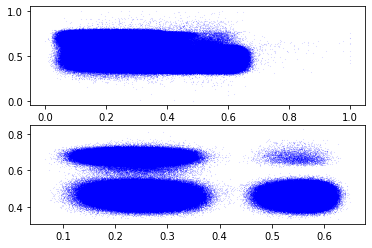

In [25]:
ch1, ch2 = 11, 14
print(columns_names[ch1+1], columns_names[ch2+1])
axes = plt.subplots(2,1)[1]
for s in range(0,60):
    axes[0].scatter(original_samples[s,ch1], original_samples[s,ch2],s=.002, c='b')
    axes[1].scatter(aligned_samples[s,ch1], aligned_samples[s,ch2],s=.002, c='b')


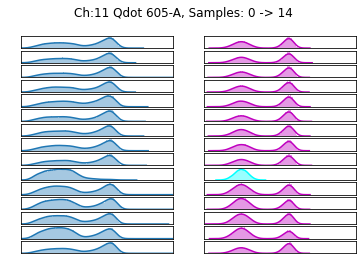

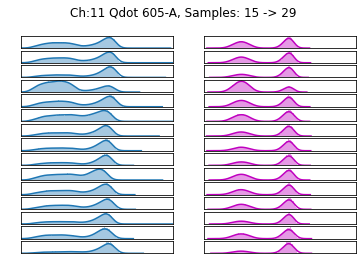

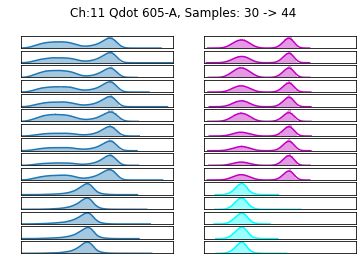

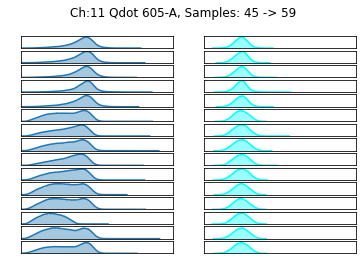

In [26]:
plot_original_vs_aligned([ch1],samples, aligned_samples,
                             60, Loc_Ref_Dict_All_Ch,
                             max_per_plt=15, root_path = None)

In [ ]:
plot = False
n_sample= 60
plot_result = False
for ch in [10,11]:
    q_alignment = gate_factor[ch]
    # q_alignment = 0.4
    print(ch,'\n','===================\n'*3)
    ch_aligned = []
    Ref_Dict_indx_by_Loc_and_Morph = Loc_Morph_Ref_Dict_All_Ch[ch]
    Loc_Ref_Dict_Ch =Loc_Ref_Dict_All_Ch[ch]
    types_of_alignment = []
    for targ_num in range(n_sample):
        print(f'Sample {targ_num} **** \n')
        funcs = []
        z = samples[targ_num](ch)
        sample_aligned = copy.deepcopy(z)
        sample_orignal = copy.deepcopy(z)
        # sample_orignal = []
        gates_locations = []
        xys = []
        refs = []
        for i in range(len(samples[targ_num].gates[ch])):
            target_gate = samples[targ_num].gates[ch][i]
            ind = np.logical_and(z>=target_gate.gate[0], z<target_gate.gate[1])
            target_seg1 = target_gate.segment
            print('diff:',np.abs(target_gate.segment-target_seg1).sum())
            target_ecdf = sm.distributions.empirical_distribution.ECDF(target_seg1)
            lo_gr, mr_gr = target_gate.location_group, target_gate.morphology_group
            print('lo_gr, mr_gr',lo_gr, mr_gr)
            ref_gate = Loc_Ref_Dict_All_Ch[ch][lo_gr]
            mr_gr_ref = Ref_Dict_indx_by_Loc_and_Morph.get((lo_gr, mr_gr))
            print('\n mr_gr_ref', mr_gr_ref,'\n')
            print('target gate',target_gate,'\n')
            type_of_alignment = ''
            if mr_gr_ref:
                ref_seg1 = mr_gr_ref.segment
                if mr_gr_ref != target_gate:
                    ref_ecdf = sm.distributions.empirical_distribution.ECDF(ref_seg1)
                    ref_inv_cdf = sm.distributions.empirical_distribution.monotone_fn_inverter(ref_ecdf,
                                                                                               ref_seg1)
                    ref_inv_cdf = scipy.interpolate.BSpline(
                        ref_inv_cdf.x,
                        ref_inv_cdf.y,
                                                                     k=3,
                                                                     extrapolate=False
                                                                     )

                    func0 = lambda_warp_factory(ref_inv_cdf, target_ecdf)

                    type_of_alignment = f'Morph_IPT'
                else:
                    type_of_alignment = 'Mroph_Ref '
                    func0 = lambda x : x

            print('loc. gate is alredy ref?', ref_gate == target_gate)
            n_mi, n_mx = ref_gate.get_tight_gates(q=q_alignment)
            refs += [ref_gate.segment]
            if mr_gr_ref:
                funcf = minmaxmean_align(target_seg1 ,ref_gate.segment, n_mi, n_mx, q_alignment, func0)

                type_of_alignment = type_of_alignment + ' Loc_MinMax' if mr_gr_ref != target_gate else \
                    type_of_alignment + ' Loc_Ref'

            else:
                funcf = minmaxmean_align(target_seg1, ref_gate.segment, n_mi, n_mx,q_alignment)
                type_of_alignment ='minmax'

            funcs += [funcf]
            print('gate:\n',target_gate.gate)
            sample_orignal[ind] = z[ind]
            t = np.linspace( target_gate.tight_gate[0], target_gate.tight_gate[1], 2000)
            y = funcf(t)
            ind = ~np.isnan(y)
            xys +=[[t[ind],y[ind]]]
            types_of_alignment +=[type_of_alignment]

            if plot:
                plt.figure()
                ax1 = plt.subplot2grid((3,2), (0,0),rowspan=1, colspan=1)
                ax1.set_xlim(0,1)
                ax1.set_ylabel('reference')
                ax2 = plt.subplot2grid((3,2), (1,0),rowspan=1, colspan=1)
                ax2.set_ylabel('target')
                ax2.set_xlim(0,1)
                ax3 = plt.subplot2grid((3,2), (2,0),rowspan=1, colspan=1)
                ax3.set_ylabel('aligned')
                ax3.set_xlim(0,1)
                ax4 = plt.subplot2grid((3,2), (0,1),rowspan=3, colspan=1)

                sns.distplot(ref_seg1, ax = ax1,hist=False, bins=128)
                sns.distplot(target_seg1, ax = ax2, hist=False,bins=128)
                print('nans',np.count_nonzero(np.isnan(aligned)))
            if plot:
                sns.distplot(aligned, ax = ax3, hist=False, bins=128)
                t = np.linspace(0,1,1000)
                y = funcf(t)
                ax4.plot(t, t)
                ax4.plot(t, ref_ecdf(t))
                ax4.plot(t, ref_inv_cdf(t))

                ax4.plot(t, y)
            else:
                ax4 = None

            gates_locations += [[target_gate.gate[0], target_gate.gate[1]]]
            if plot:
                for l in [ref_gate.tight_gate[0], ref_gate.tight_gate[1]]:
                    ax4.axhline(l)
                for l in [target_gate.tight_gate[0], target_gate.tight_gate[1]]:
                    ax4.axvline(l)
                ax4.grid(True)
        print(plot)
        model = Earth(penalty=2, smooth=True, max_degree=1, )
        # comp_func = combine_funcs(model, xys, plot=plot, ax=ax4)
        comp_func = combine_funcs(model, xys, funcs, gates_locations, plot=plot, ax=ax4)
        comp_func_dict[ch, targ_num] = comp_func
        funcs_dict[ch, targ_num] = funcs
        if plot:
            plt.figure()
            ax1 = plt.subplot2grid((3,2), (0,0),rowspan=1, colspan=1)
            ax1.set_xlim(0,1)
            ax1.set_ylabel('reference')
            ax2 = plt.subplot2grid((3,2), (1,0),rowspan=1, colspan=1)
            ax2.set_ylabel('target')
            ax2.set_xlim(0,1)
            ax3 = plt.subplot2grid((3,2), (2,0),rowspan=1, colspan=1)
            ax3.set_ylabel('aligned')
            ax3.set_xlim(0,1)
            ax4 = plt.subplot2grid((3,2), (0,1),rowspan=3, colspan=1)

            sns.distplot(np.concatenate(refs), ax = ax1,hist=False, bins=128)
            sns.distplot(samples[targ_num](ch), ax = ax2, hist=False,bins=128)
            aligned = comp_func(samples[targ_num](ch))
            sns.distplot(aligned, ax = ax3, hist=False, bins=128)

            # plt.figure()
        sample_aligned = comp_func(sample_orignal)
        aligned_samples[targ_num, ch] = sample_aligned
        original_samples[targ_num, ch] = sample_orignal
        gates_locations_dict[targ_num, ch] = gates_locations
    #%%
    colors = 'blue,orange,g,r,coral,cyan,m,steelblue,brown,y,gray,k'.split(',')

    if plot_result:
        r = 15
        # for i in range(n_sample):
        #     if i%r==0:
        #         axes = plt.subplots(np.minimum(n_sample, r),2)[1]
        #     samp = samples[i]
        #     sns.distplot(samp(ch), ax=axes[i%r,0],hist=True,bins=128, label=f'orig:{i}')
        #     lo_gr = samp.gates[ch][0].location_group
        #     ref_gate = Loc_Ref_Dict_All_Ch[ch][lo_gr]
        #
        #     z = aligned_samples[i, ch]
        #     b = False
        #     for gate in samp.gates[ch]:
        #         lo_gr = gate.location_group
        #         ref_gate = Loc_Ref_Dict_All_Ch[ch][lo_gr]
        #         if functools.reduce(lambda x,y: x | (y==ref_gate),samp.gates[ch],False):
        #             b = True
        #             break
        #     if b:
        #         sns.distplot(z ,ax= axes[i%r,1], hist= False, color = colors[lo_gr+4])
        #     else:
        #         sns.distplot(z, ax= axes[i%r,1], hist= True, bins=128, color = colors[lo_gr+4])
        #
        #     # axes[i%r,1].set_xticks([])
        #     axes[i%r,0].set_ylabel(' ')
        #     axes[i%r,0].set_xlabel(types_of_alignment[i])
        #     axes[i%r,0].set_xlim(0,1)
        #     axes[i%r,1].set_xlim(0,1)
        #     axes[i%r,1].set_ylabel('')

        for i in range(n_sample):
            if i%r==0:
                axes = plt.subplots(np.minimum(n_sample, r),2)[1]
            samp = samples[i]
            t_o, pdf_o = samp.pdfs[ch]
            lo_gr = samp.gates[ch][0].location_group
            ref_gate = Loc_Ref_Dict_All_Ch[ch][lo_gr]

            z = aligned_samples[i, ch]
            sns_KDE = sns._statistics.KDE(bw_method=kde_window[ch])
            pd_a, t_a = sns_KDE(x1 = z[~np.isnan(z)].flatten())

            for gate in samp.gates[ch]:
                lo_gr = gate.location_group
                ref_gate = Loc_Ref_Dict_All_Ch[ch][lo_gr]
                a, b = gate.gate[0], gate.gate[1]
                ind = np.logical_and(t_a>=a, t_a<b)
                axes[i%r,1].plot(t_a[ind], pd_a[ind], color = colors[lo_gr+4])

                ind = np.logical_and(t_o>=a, t_o<b)
                axes[i%r,0].plot(t_o[ind], pdf_o[ind], color = colors[lo_gr+4])


            # axes[i%r,1].set_xticks([])
            axes[i%r,0].set_xlim(0,1)
            axes[i%r,1].set_xlim(0,1)
            axes[i%r,1].set_ylabel('')



In [ ]:
print(comp_func_dict[ch,0])
t = np.linspace(0,1.4,1000)
ch= 14
plt.plot(t, t, linewidth=5)
for n in range(0,60):
    plt.plot(t, comp_func_dict[ch,n](t))
    # for i, f in enumerate(funcs_dict[ch,n]):
    #     loc = gates_locations_dict[n,ch][i]
    #     t = np.linspace(loc[0],loc[1],1000)
    #     plt.plot(t, gaussian_filter1d( f(t), 1) )

In [ ]:
print(ch)
print(aligned_samples.keys())
%matplotlib qt


In [ ]:
aligned_samples_data = []
Y_data = []
original_samples_data = []
for s in range(n_sample):
    sample = []
    orig_sample = []
    for ch in [8,14]:
    # for ch in range(15):
        samp_ch = aligned_samples[s, ch].reshape(-1, 1)
        orig_samp_ch = original_samples[s, ch].reshape(-1, 1)
        sample +=[samp_ch]
        orig_sample +=[orig_samp_ch]
    sample = np.concatenate(sample, axis=1 )
    y = np.zeros([sample.shape[0],1], dtype=np.int)+s
    sample = np.concatenate([y, sample], axis = 1)
    orig_sample = np.concatenate(orig_sample, axis=1 )
    orig_sample = np.concatenate([y, orig_sample], axis = 1)
    aligned_samples_data += [sample]
    original_samples_data += [orig_sample]

aligned_samples_data = np.concatenate(aligned_samples_data)
original_samples_data = np.concatenate(original_samples_data)

In [ ]:
print(np.unique(aligned_samples_data[:,0]))
print(aligned_samples_data.shape)

In [ ]:
plt.figure()
for s in range(60):
    c1, c2 = aligned_samples[s, 8], aligned_samples[s, 14]
    plt.scatter(c1, c2, c='b', s=.01)
    # c1, c2 = original_samples[s, 8], original_samples[s, 14]
    # plt.scatter(c1, c2, c='b', s=.01)

In [ ]:
# for i in range(1,13,3):
ch1, ch2 = 0, 1
fig, axes = plt.subplots(1,2)
fig.suptitle(f'ch:{ch1}-{ch2}')
axes = axes.flatten()
axes[0].scatter(original_samples_data[:, ch1], original_samples_data[:, ch2])
axes[1].scatter(aligned_samples_data[:, ch1], aligned_samples_data[:, ch2])

In [ ]:
print(original_samples_data[:,2])
# print(aligned_samples_data.shape)

In [ ]:
for ch in range(9,11,1):
    ch1 = ch
    ch2 = ch+1
    fig = plt.figure()
    fig.suptitle(f'{(ch1-1, ch2-1)}, {columns_names[ch1]} - {columns_names[ch2]} ', fontsize=15)
    line_ax1 = plt.subplot2grid((5,5), (0,2), rowspan=3, colspan=3)
    line_ax2 = plt.subplot2grid((5,5), (3,0), rowspan=2, colspan=2)
    side_ax1 = plt.subplot2grid((5,5), (0,0), rowspan=3, colspan=1)
    side_ax2 = plt.subplot2grid((5,5), (0,1), rowspan=3, colspan=1)
    side_ax1.set_ylim(0,1)
    side_ax2.set_ylim(0,1)
    bottom_ax1 = plt.subplot2grid((5,5), (3,2),rowspan=1, colspan=3)
    bottom_ax2 = plt.subplot2grid((5,5), (4,2), rowspan=1, colspan=3)
    bottom_ax1.set_xlim(0,1)
    bottom_ax2.set_xlim(0,1)

    for i, line_ax in enumerate([line_ax1, line_ax2]):
        indx = original_samples_data[:,0]==i
        plot_lines(
            original_samples_data[:,[ch1,ch2]][indx] ,
            aligned_samples_data[:,[ch1,ch2]][indx] ,
                   n_lines=10000,linewidth=.2,
                    s1=5, s2=10,ax = line_ax
                   )
        line_ax.set_xlim(0,1)
        line_ax.set_ylim(0,1)

    for s in range(n_sample):
        indx = original_samples_data[:,0]==s

        sns_KDE = sns._statistics.KDE()
        pd_a, t_a = sns_KDE(x1 = original_samples_data[:,ch2][indx].flatten())
        side_ax2.plot(pd_a, t_a)
        sns_KDE = sns._statistics.KDE()
        pd_a, t_a = sns_KDE(x1 = aligned_samples_data[:,ch2][indx][~np.isnan(aligned_samples_data[:,ch2][indx])].flatten())
        side_ax1.plot(pd_a, t_a)

        sns.distplot(original_samples_data[:,ch1][indx], hist=False, ax=bottom_ax1)
        sns.distplot(aligned_samples_data[:,ch1][indx], hist=False, ax=bottom_ax2)

    fig.set_size_inches(28.5, 10.5)
    fig.tight_layout()
    fig.savefig(f'imgs/Grid Warp {ch1-1}_{ch2-1}')

In [ ]:
cleaned_and_aligned = aligned_samples_data[~np.isnan(aligned_samples_data).any(axis=1)]
header = ','.join(columns_names[:-2])
np.savetxt(f'Aligned 080322-ENU-Mouse CSP.csv',cleaned_and_aligned,delimiter=',',header=header,
           fmt=','.join(['%i'] + ['%1.4f']*15),comments='')

In [ ]:
loaded = np.loadtxt('Aligned 080322-ENU-Mouse CSP.csv', delimiter=',', skiprows=1)

In [ ]:
for i, c in enumerate(columns_names):
    print(i, c)

In [ ]:
for i in range(1):
    fig, axes = plt.subplots(1,2)
    axes = axes.flatten()
    # ch1, ch2 = i, i+1
    ch1, ch2 = 3, 4
    print(columns_names[ch1], columns_names[ch2])
    axes[0].set_title(f'original:{(ch1-1, ch2-1)}')
    axes[0].scatter(original_samples_data[:, ch1], original_samples_data[:, ch2],s=.01)
    axes[1].scatter(loaded[:, ch1], loaded[:, ch2], s=.01)
    axes[1].set_title(f'aligned:{(ch1-1, ch2-1)}')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[0].set_xlabel(columns_names[ch1], fontdict={"size":15})
    axes[0].set_ylabel(columns_names[ch2], fontdict={"size":15})
    axes[1].set_xlabel(columns_names[ch1], fontdict={"size":15})
    axes[1].set_ylabel(columns_names[ch2], fontdict={"size":15})
    fig.set_size_inches(28.5, 10.5)
    fig.tight_layout()
    fig.savefig(f'imgs/Scatter_{ch1-1}_{ch2-1}')

In [ ]:
plot_gate_lines(data_handler, 10,6)
